<a href="https://colab.research.google.com/github/fabiocarrara/mbd-dlmra/blob/main/ol2_object_detection_and_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLMRA OpenLab \#2
-------------------

# Object Detection and Verification in Images

You'll learn to:

*   Detect objects in images using a pretrained DCNN object detector.
*   Perform verification (aka open-set recognition) via similarity search.

We will build:

* a simple Celebrity Look Alike application.

## Using Pretrained Object Detectors

Many pretrained generic object detectors are publicly available and ready to use. Those are usually trained on publicly available research datasets for object detection like [Microsoft COCO](https://cocodataset.org/) or Google's [OpenImages](https://storage.googleapis.com/openimages/web/index.html).

Let's try out a generic object detector we can find on [Tensorflow Hub](https://tfhub.dev).

In [ ]:
import collections
import itertools
import random

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from tqdm.auto import tqdm 

First, let's pick an image we want to analize. Here, we download an image in the COCO dataset containing a person, a car, and a dog.

Feel free to navigate and choose another image from the [COCO Dataset Explore](https://cocodataset.org/#explore) page.

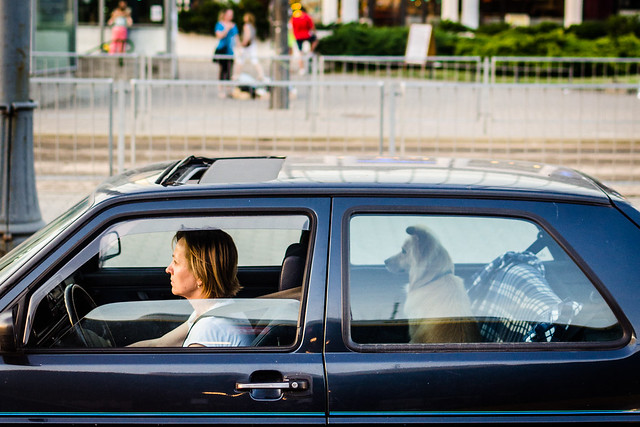

In [ ]:
! wget http://farm8.staticflickr.com/7426/9097479167_511204af23_z.jpg -q -O photo.jpg
Image.open('photo.jpg')

We define a function to read an image and convert it to a TensorFlow tensor that is ready to be fed to our detector.

In [ ]:
def load_image(path):
  image_data = tf.io.read_file(path)
  image = tf.image.decode_image(image_data, channels=3, expand_animations=False)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.expand_dims(image, axis=0)
  return image

image_tensor = load_image('photo.jpg')

Now let's load a pretrained model from TensorFlow Hub. Using the [tfhub.dev](https://tfhub.dev) portal, we choose an object detection model trained on [OpenImagesV4](https://storage.googleapis.com/openimages/web/download_v4.html) that can detect up to 600 object classes.

The list of the detectable classes is available as a [CSV file](https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv).

Let's pick a Faster RCNN model with an Inception ResNet V2 as backbone. You can find more info on its usage at the URL of the model:

https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1

We use the tensorflow hub python library to load the model passing the model's URL.

In [ ]:
# detector = hub.load('https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1').signatures['default']
detector = hub.load('https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1').signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Let's run the detector on our image and inspect the output.

In [ ]:
detector_output = detector(image_tensor)#, as_dict=True)
detector_output

{'detection_boxes': <tf.Tensor: shape=(100, 4), dtype=float32, numpy=
 array([[0.34357953, 0.        , 1.        , 0.97651535],
        [0.5261078 , 0.59593725, 0.82120323, 0.7524249 ],
        [0.5570379 , 0.26399818, 0.6898203 , 0.31596693],
        [0.5170708 , 0.20239678, 0.84050024, 0.4508108 ],
        [0.68617827, 0.23428191, 0.8218862 , 0.44007114],
        [0.5127997 , 0.18408662, 0.82259136, 0.44825697],
        [0.0474922 , 0.33260143, 0.16999331, 0.37391055],
        [0.00485586, 0.45277658, 0.1760583 , 0.49815646],
        [0.00462933, 0.1677225 , 0.16741033, 0.20938762],
        [0.02955756, 0.17222297, 0.12485329, 0.20835114],
        [0.01468591, 0.3302045 , 0.20401222, 0.37776935],
        [0.00755301, 0.45271933, 0.17452006, 0.49730256],
        [0.0235159 , 0.45641986, 0.11888127, 0.49349964],
        [0.02266803, 0.36732197, 0.22380094, 0.41600427],
        [0.00357747, 0.16761613, 0.14950156, 0.2100652 ],
        [0.02195355, 0.33090532, 0.21124077, 0.3771946 ],
  

Most object proposals are low-confidence predictions. Let's filter out weak predictions based on the `detection_scores` and let's visualize the results by drawing on the original image.

In [ ]:
is_confident = detector_output['detection_scores'] > 0.3

labels = detector_output['detection_class_entities'][is_confident]
boxes = detector_output['detection_boxes'][is_confident]

labels = [l.decode('utf8') for l in labels.numpy().tolist()]  # byte strings to python strings
boxes = boxes.numpy()

In [ ]:
# defaultdict runs the 'pick_random_color' function when we ask for a non-existent key, generating a new color
pick_random_color = lambda: tuple(np.random.randint(0, 256, 3).tolist())
colors = collections.defaultdict(pick_random_color)

def draw_boxes(image_path, boxes, labels):
  image = Image.open(image_path).convert('RGB')
  draw = ImageDraw.Draw(image)
  hwhw = np.tile((image.height, image.width), 2)
  boxes = boxes * hwhw
  font = ImageFont.truetype('LiberationSans-Regular.ttf', size=20)
  for (y0, x0, y1, x1), label in zip(boxes, labels):
    color = colors[label]
    draw.line((x0, y0, x1, y0, x1, y1, x0, y1, x0, y0), fill=color, width=4)
    tw, th = font.getsize(label)
    draw.rectangle(((x0, y0), (x0 + tw, y0 + th)), fill=color)
    draw.text((x0, y0), label, fill="white", anchor='mm', font=font)

  return image

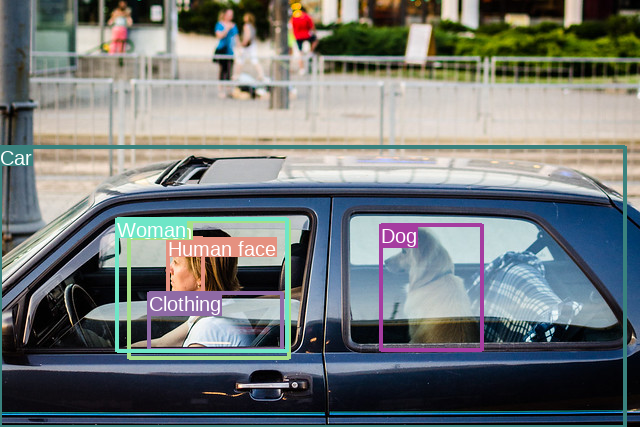

In [ ]:
draw_boxes('photo.jpg', boxes, labels)

## Use Case: Celebrity Look Alike

We will see how we can combine object detection and similarity search technologies for building a specific demo application: Celebrity Look Alike!

Given a picture of the user as query, we want to retrieve celebrities' photos inside our database that looks most like the query.

### Getting Started

We will use [Kaggle](https://www.kaggle.com/) as our source of datasets. This let us download datasets directly from Kaggle to Colab without manually upload the data at the beginning of every session.

- Register on Kaggle (you can login with a Google Account).
- Go to Account Settings > "Account" Tab > Click on "Create New API Token".
- Save the generated `kaggle.json` file somewhere on your PC.

Next, we install the `kaggle` command line utility on Colab.

In [ ]:
!pip install -q kaggle

Upload the `kaggle.json` file to Colab...

In [ ]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


... and let's put it in the right place and give it the right file permissions.

In [ ]:
%%bash
mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

Now, we can download datasets using the `kaggle` command as follows:



In [ ]:
%%bash
kaggle datasets download -d atulanandjha/lfwpeople
mkdir -p data && unzip -q -d data lfwpeople.zip
tar xf data/lfw-funneled.tgz -C data/

100%|##########| 232M/232M [00:02<00:00, 87.6MB/s]


We just downloaded and extracted a compressed version of [Labelled Face in the Wild](https://www.kaggle.com/atulanandjha/lfwpeople), a collection of photos of celebrities' faces that we will use as our search database.

### Face Detector and Face Descriptor

We will use pretrained publicly available networks for detecting faces and extract representations that we will use to perform face similarity search.

- As **Face Detector**, we will use the [`mtcnn`](https://pypi.org/project/mtcnn/) library that packs a pretrained object detector network (TensorFlow implementation of MTCNN, more info at the project page) specialized in detecting faces.

- As **Face Descriptor**, we will employ the [`keras-vggface`](https://github.com/rcmalli/keras-vggface) library that packs several networks trained on [VGGFace](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/), a large-scale dataset for face recognition.

Let's install them.

In [ ]:
!pip install mtcnn
!pip install keras-vggface keras_applications

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 51kB 4.0MB/s 


In [ ]:
import itertools
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from scipy.spatial.distance import cdist
from tqdm.auto import tqdm

from mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

We need a face image as query for our demo application.
We will use the webcam to take a picture of the user;
alternatively, you can upload an image or choose one from the LFW dataset.

In [ ]:
! wget https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Silvio_Berlusconi_2018.jpg/800px-Silvio_Berlusconi_2018.jpg -O photo2.jpg

--2021-05-24 17:10:46--  https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Silvio_Berlusconi_2018.jpg/800px-Silvio_Berlusconi_2018.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195347 (191K) [image/jpeg]
Saving to: ‘photo2.jpg’

photo2.jpg          100%[===================>] 190.77K  --.-KB/s    in 0.06s   

2021-05-24 17:10:47 (2.91 MB/s) - ‘photo2.jpg’ saved [195347/195347]



We use the snippet provided by Colab to take a picture with the webcam.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


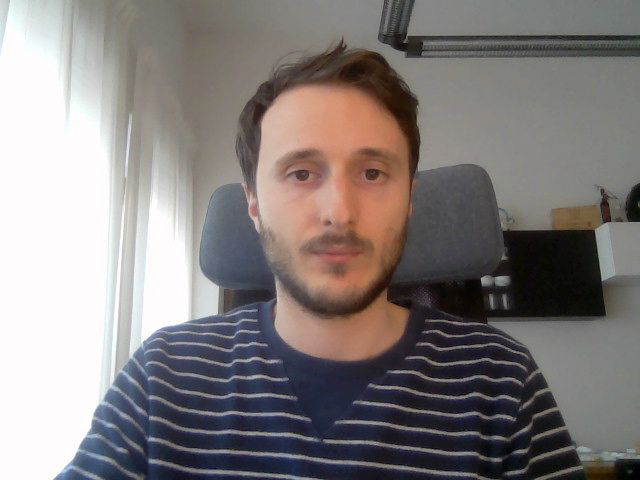

In [ ]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image.open(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Next, we load the pretrained face detector, apply it to our image, and inspect the detector output.

In [ ]:
detector = MTCNN()

In [ ]:
from PIL import Image
img = Image.open('photo.jpg').convert('RGB')  # try also photo2.jpg
img_np = np.array(img)
det = detector.detect_faces(img_np)
det

[{'box': [255, 86, 150, 208],
  'confidence': 0.9999692440032959,
  'keypoints': {'left_eye': (302, 174),
   'mouth_left': (306, 252),
   'mouth_right': (364, 252),
   'nose': (335, 216),
   'right_eye': (372, 174)}}]

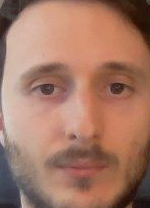

In [ ]:
x, y, w, h = det[0]['box']
face = img.crop((x, y, x + w, y + h))
face

Now, let's also load the face feature extractor model and apply it to our face image.

In [ ]:
vggface = VGGFace(model='resnet50', include_top=False)

94699520/94694792 [==============================] - 1s 0us/step


In [ ]:
face_np = np.array(face.resize((224, 224)))
face_np = face_np[None, :].astype(np.float32)
face_np = preprocess_input(face_np, version=2)
my_descriptor = vggface(face_np).numpy().squeeze()
my_descriptor

array([1.1521957 , 2.0674427 , 2.439177  , ..., 0.50026846, 1.1545702 ,
       7.7891316 ], dtype=float32)

### Database Processing

Now that we have all the networks up and running, let's prepare our database for implementing our celebrity look alike app.

In this demo applcation, we will select a subset of the LFW dataset to maintain a low processing time for our database.
Let's pick the top-$n$ identities with most images.

In [ ]:
n = 150

image_list = Path('data/lfw_funneled/').glob('*/*.jpg')
image_list = sorted(image_list)

names = [image_path.parent.name for image_path in image_list]
common = Counter(names).most_common(n)
common

[('George_W_Bush', 530),
 ('Colin_Powell', 236),
 ('Tony_Blair', 144),
 ('Donald_Rumsfeld', 121),
 ('Gerhard_Schroeder', 109),
 ('Ariel_Sharon', 77),
 ('Hugo_Chavez', 71),
 ('Junichiro_Koizumi', 60),
 ('Jean_Chretien', 55),
 ('John_Ashcroft', 53),
 ('Jacques_Chirac', 52),
 ('Serena_Williams', 52),
 ('Vladimir_Putin', 49),
 ('Luiz_Inacio_Lula_da_Silva', 48),
 ('Gloria_Macapagal_Arroyo', 44),
 ('Arnold_Schwarzenegger', 42),
 ('Jennifer_Capriati', 42),
 ('Laura_Bush', 41),
 ('Lleyton_Hewitt', 41),
 ('Alejandro_Toledo', 39),
 ('Hans_Blix', 39),
 ('Nestor_Kirchner', 37),
 ('Andre_Agassi', 36),
 ('Alvaro_Uribe', 35),
 ('Megawati_Sukarnoputri', 33),
 ('Silvio_Berlusconi', 33),
 ('Tom_Ridge', 33),
 ('Kofi_Annan', 32),
 ('Roh_Moo-hyun', 32),
 ('Vicente_Fox', 32),
 ('David_Beckham', 31),
 ('John_Negroponte', 31),
 ('Guillermo_Coria', 30),
 ('Recep_Tayyip_Erdogan', 30),
 ('Bill_Clinton', 29),
 ('Mahmoud_Abbas', 29),
 ('Jack_Straw', 28),
 ('Juan_Carlos_Ferrero', 28),
 ('Ricardo_Lagos', 27),
 ('Gra

Once we selected the identities, we pick 3 images per person.

In [ ]:
common_people, common_freq = zip(*common)

n_images_per_person = 3

selected_people = []
selected_images = []
for person, person_images in itertools.groupby(image_list, key=lambda x: x.parent.name):
  if person not in common_people:
    continue

  person_images = list(person_images)
  if len(person_images) >= n_images_per_person:
    selected_people.append(person)
    selected_images += person_images[:n_images_per_person]
  
names = [image_path.parent.name for image_path in selected_images]
len(selected_images)

450

Let's use the face detector to extract all faces from the selected images comprising our database.

*NOTE*: each image can contain more than a face! We need to handle this situation.

In [ ]:
all_faces = []

for image_path in tqdm(selected_images):
  image_pil = Image.open(image_path).convert('RGB')
  image_np = np.array(image_pil)
  faces = detector.detect_faces(image_np)
  all_faces.append(faces)

In [ ]:
# find the image with most faces ...
image_with_most_faces = max(enumerate(map(len, all_faces)), key=lambda x: x[1])
image_index, n_faces = image_with_most_faces

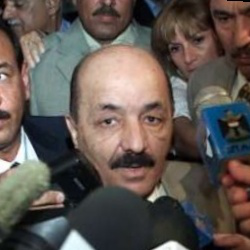

[{'box': [78, 63, 95, 135],
  'confidence': 0.9997507929801941,
  'keypoints': {'left_eye': (107, 121),
   'mouth_left': (114, 169),
   'mouth_right': (152, 166),
   'nose': (136, 147),
   'right_eye': (152, 118)}},
 {'box': [166, 18, 50, 64],
  'confidence': 0.9946179986000061,
  'keypoints': {'left_eye': (175, 48),
   'mouth_left': (184, 72),
   'mouth_right': (199, 66),
   'nose': (184, 59),
   'right_eye': (197, 40)}},
 {'box': [77, -26, 54, 60],
  'confidence': 0.9684844017028809,
  'keypoints': {'left_eye': (96, -3),
   'mouth_left': (97, 17),
   'mouth_right': (119, 16),
   'nose': (109, 6),
   'right_eye': (119, -5)}},
 {'box': [1, -6, 41, 43],
  'confidence': 0.9553343057632446,
  'keypoints': {'left_eye': (5, 9),
   'mouth_left': (11, 28),
   'mouth_right': (22, 24),
   'nose': (5, 19),
   'right_eye': (17, 4)}}]

In [ ]:
# ... and visualize it
display(Image.open(selected_images[image_index]))
all_faces[image_index]

Now that we have the detection of all the faces, we use the feature extractor to obtain face descriptors.

*NOTE*: for images containing multiple faces, we choose to pick only the face detected with the highest confidence by the face detector.

*This may take a while depending on the number of identities $k$ we have to process.*

In [ ]:
descriptors = []

for image_path, faces in zip(tqdm(selected_images), all_faces):
  image_pil = Image.open(image_path).convert('RGB')
  image_np = np.array(image_pil)

  face = max(faces, key=lambda x: x['confidence'])  # keep only the top confidence face
  x, y, w, h = face['box']
  face_pil = image_pil.crop((x, y, x + w, y + h)).resize((224, 224))
  face_np = np.array(face_pil)[None, ...].astype(np.float32)
  face_np = preprocess_input(face_np, version=2)

  face_descriptor = vggface(face_np).numpy().squeeze()

  descriptors.append(face_descriptor)


In [ ]:
db_descriptors = np.stack(descriptors)

In [ ]:
db_descriptors.shape, my_descriptor.shape

((450, 2048), (2048,))

### Perform the query

Now that we have all the descriptors of our database extracted, we can compare them to our query and retrieve the $k$ most similar items.

Adrien_Brody 0.4156453488466596


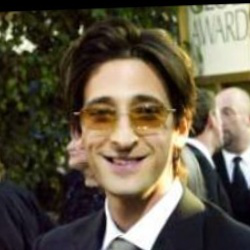

Adrien_Brody 0.41215163957600676


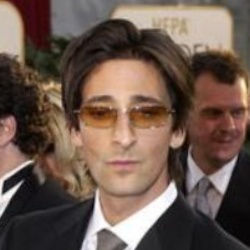

Juan_Carlos_Ferrero 0.40661970783299395


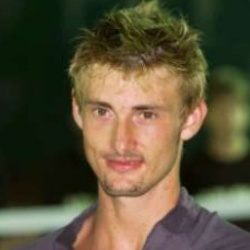

Recep_Tayyip_Erdogan 0.4039408882482438


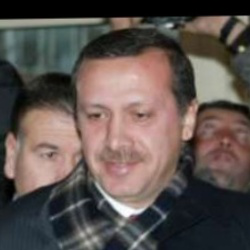

Rubens_Barrichello 0.3837140274765761


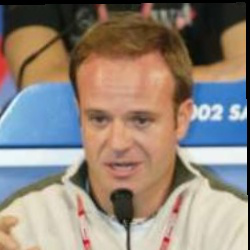

Tommy_Franks 0.37244162457092744


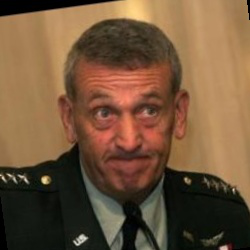

Alvaro_Uribe 0.3709768693150559


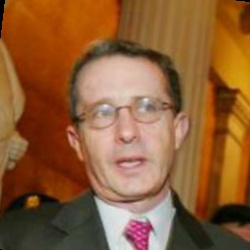

Tim_Henman 0.37032819162662656


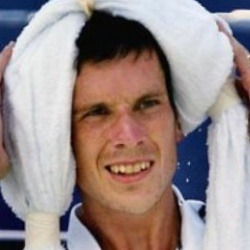

Michael_Schumacher 0.36801890057373643


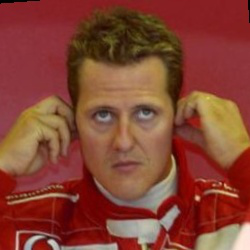

Recep_Tayyip_Erdogan 0.36649661252487076


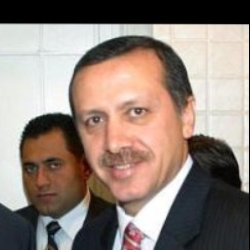

In [ ]:
k = 10

# cdist's cosine returns a *distance* (1 - cosine similarity).
distances = cdist(my_descriptor.reshape(1, -1), db_descriptors, metric='cosine')
scores = 1 - distances.squeeze()
rank = scores.argsort()[::-1][:k]

for i in rank:
  image_path = selected_images[i]
  print(image_path.parent.name, scores[i])
  display(Image.open(image_path))

### Using "template" descriptors as database

In order to obtain a more robust description of an identity, in face verification, we often compare the query descriptor to an **identity template** generated by averaging descriptors coming from multiple images of the same identity.

This creates a descriptor that is more robust to noise/disturbances in database images and solves any unbalancing problem of identities (otherwise identities with more faces could be retrieved more often).

In [ ]:
from sklearn.preprocessing import normalize  # L2 normalization
db_templates = normalize(db_descriptors).reshape(n, n_images_per_person, -1).mean(axis=1)

In [ ]:
db_templates.shape

(150, 2048)

Adrien_Brody 0.43398662243725483


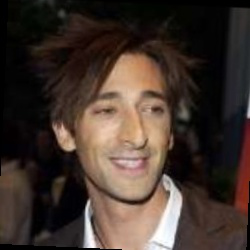

Jennifer_Garner 0.40088378040847017


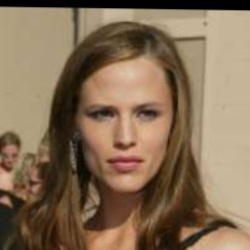

Recep_Tayyip_Erdogan 0.39284123190063824


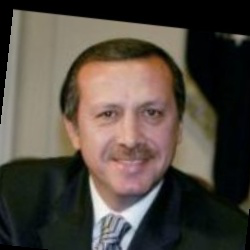

Alvaro_Uribe 0.3801069963183119


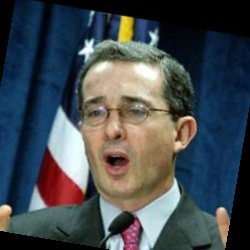

Juan_Carlos_Ferrero 0.37811929796320665


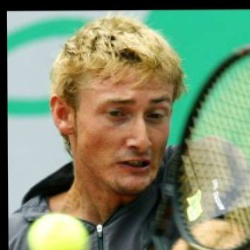

Mohammed_Al-Douri 0.37720782038548095


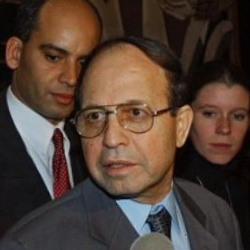

Michael_Schumacher 0.374275590573494


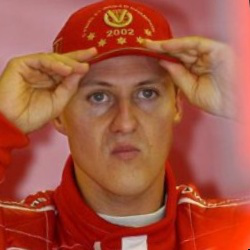

Jose_Maria_Aznar 0.3702103833375331


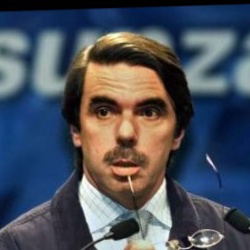

Mohammad_Khatami 0.3701306603534309


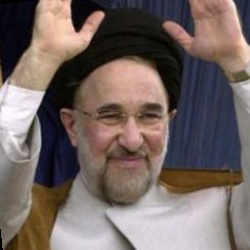

Julianne_Moore 0.36707111254460734


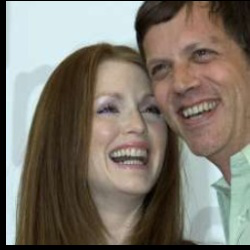

In [ ]:
# cdist's cosine returns a *distance* (1 - cosine similarity).
distances = cdist(my_descriptor.reshape(1, -1), db_templates, metric='cosine')
scores = 1 - distances.squeeze()
rank = scores.argsort()[::-1][:k]

for i in rank:
  image_path = selected_images[i * n_images_per_person]
  print(image_path.parent.name, scores[i])
  display(Image.open(image_path))

## Additional Resources



*   [Object Detector & Instance Segmentation Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) (PyTorch)
*   [Instance Segmentation Finetuning Tutorial](https://www.tensorflow.org/tutorials/images/segmentation) (TensorFlow)

